# Experiment Analysis:
The notebook provides a evaluation framework of a prediction for a given experiment

**Inputs**:  Config File of the experiment <br />
**Output**:  Visualisation of prediction, Train-val loss and accuracy graphs

In [1]:
import sys
sys.path.append("../")

In [2]:
import torch
import numpy as np
import json
import matplotlib.pyplot as plt
import cv2
import os
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from torchvision import transforms

from seger.datasets.seg_dataset import LaneDataset
from seger.models.networks import get_network
from seger.metric import IOU,fscore_batch,fscore
from Notebooks.utils import *

In [3]:
config_file = "../cfgs/baseline-7.json"

In [4]:
with open(config_file) as fp:
    cfg = json.load(fp)

Derive useful parameters from the notebook

In [5]:
arch_name = cfg["arch"]["arch_name"]
experiment_name = cfg["model_stuff"]["exp_name"]
MODEL_PATH = "../Experiments/{}/best.pth".format(experiment_name)
cfg["arch"]["arch_kwargs"]["pretrained"] = False
input_size = cfg["train"]["width"], cfg["train"]["height"]

cfg["data"]["train_data"] = "../" + cfg["data"]["train_data"]
cfg["data"]["valid_data"] = "../" + cfg["data"]["valid_data"]
cfg["data"]["train_root"] = "../" + cfg["data"]["train_root"]
cfg["data"]["label_root"] = "../" + cfg["data"]["label_root"]

train_file = cfg["data"]["train_data"]
val_file = cfg["data"]["valid_data"]
train_root = cfg["data"]["train_root"]
label_root = cfg["data"]["label_root"]


In [6]:
model = get_network(cfg["data"]["input_channels"], cfg["data"]["num_classes"], cfg["arch"]["arch_name"], cfg["arch"]["arch_kwargs"])
model.cuda()
model.load_state_dict(torch.load(MODEL_PATH)["model_weights"])

Initializing ERFNet...


<All keys matched successfully>

In [7]:
train_list, val_list = get_list_files(train_file,val_file)    

In [11]:
cfg["train"]["width"], cfg["train"]["height"] = 512, 512 
input_size = cfg["train"]["width"], cfg["train"]["height"]

In [12]:
train_dataset = LaneDataset(cfg, augmentations = True , train=True, mode="train")

In [18]:
train_choices = np.random.randint(0,len(train_dataset),5)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


IOU :0.2887233358726164


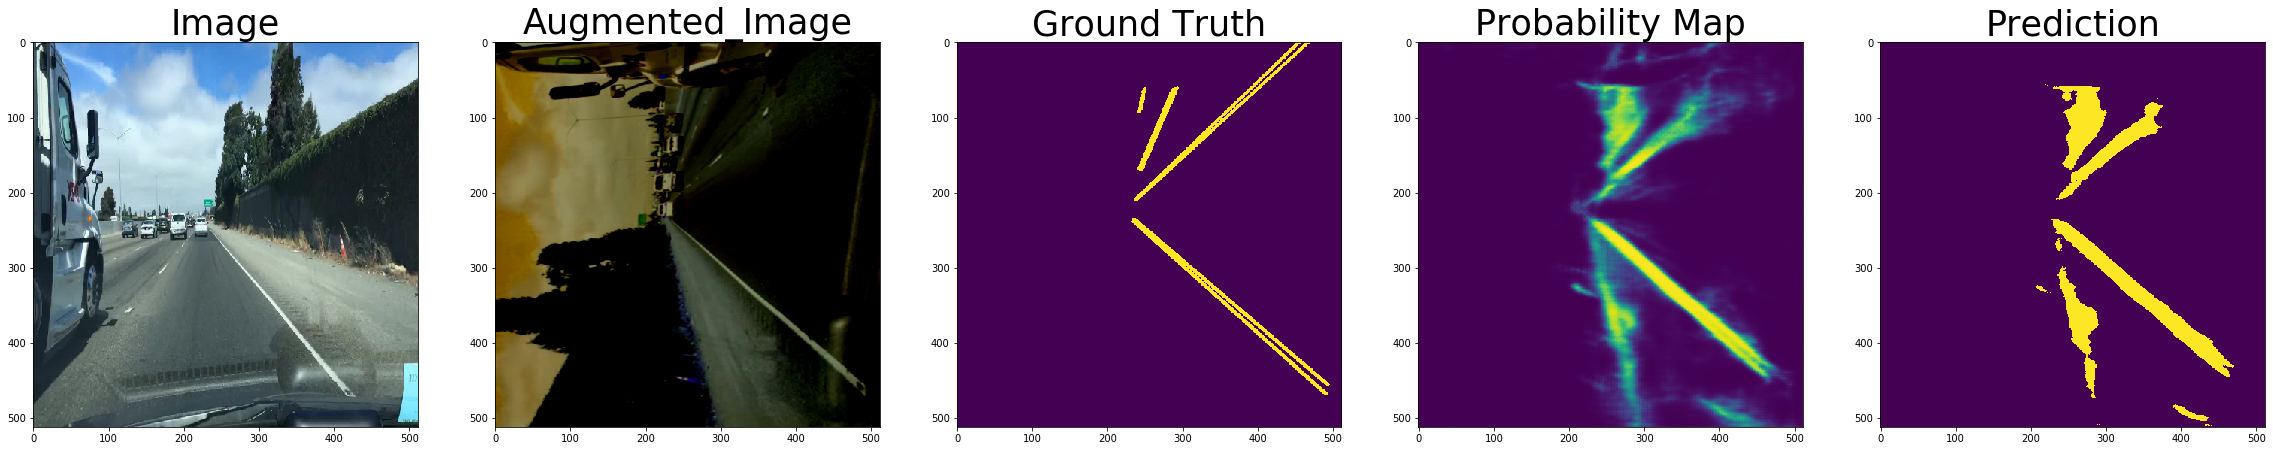

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


IOU :0.065813405249861


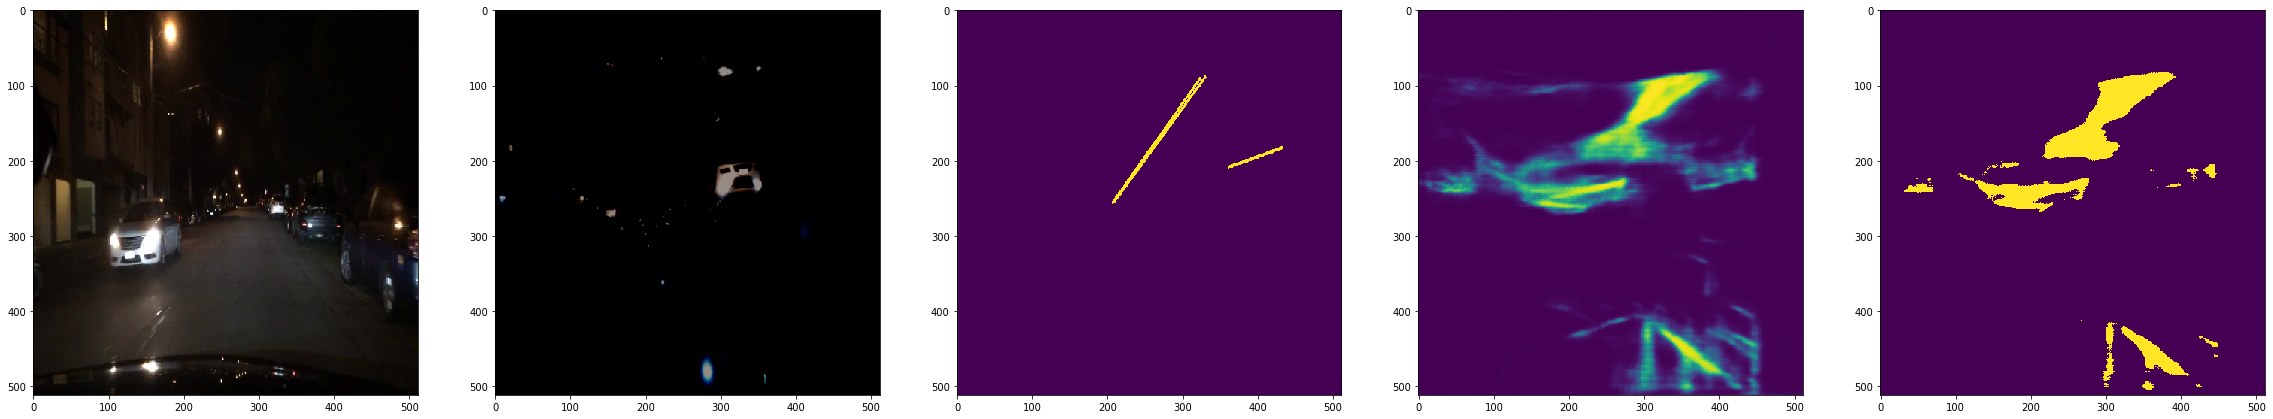

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


IOU :0.31622927867942413


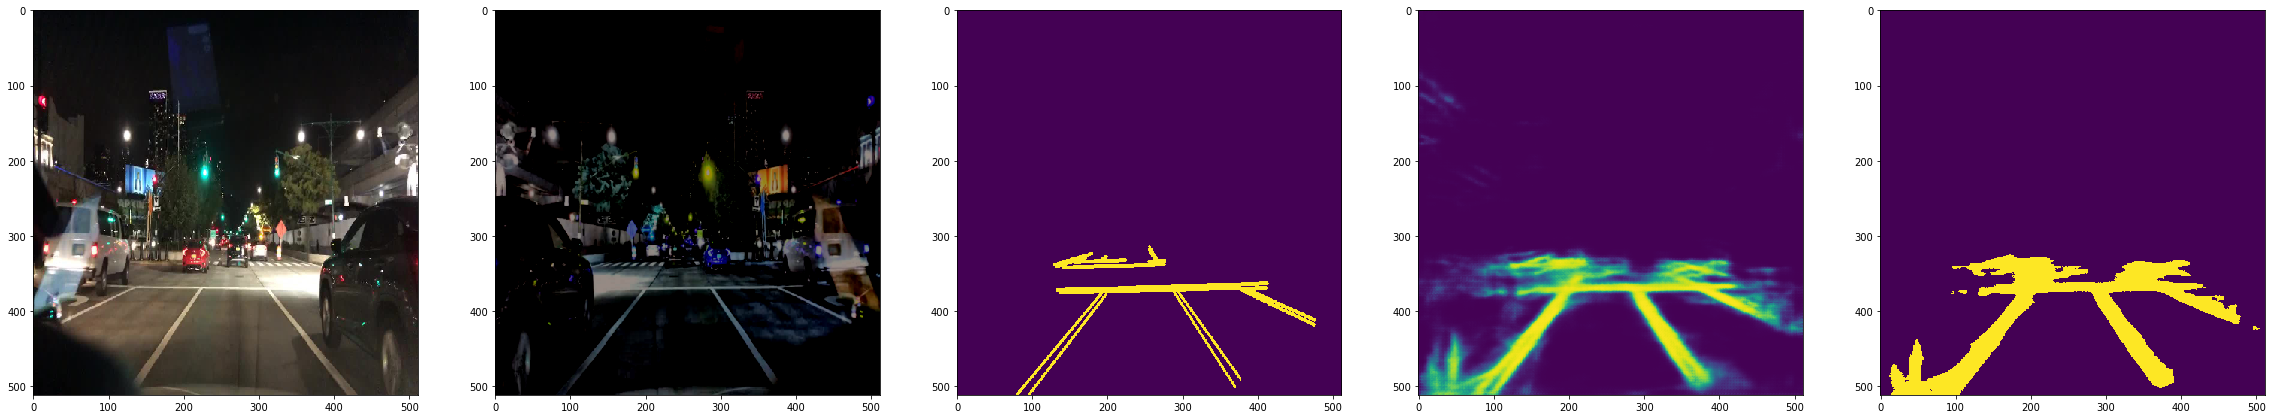

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


IOU :0.22032347930562873


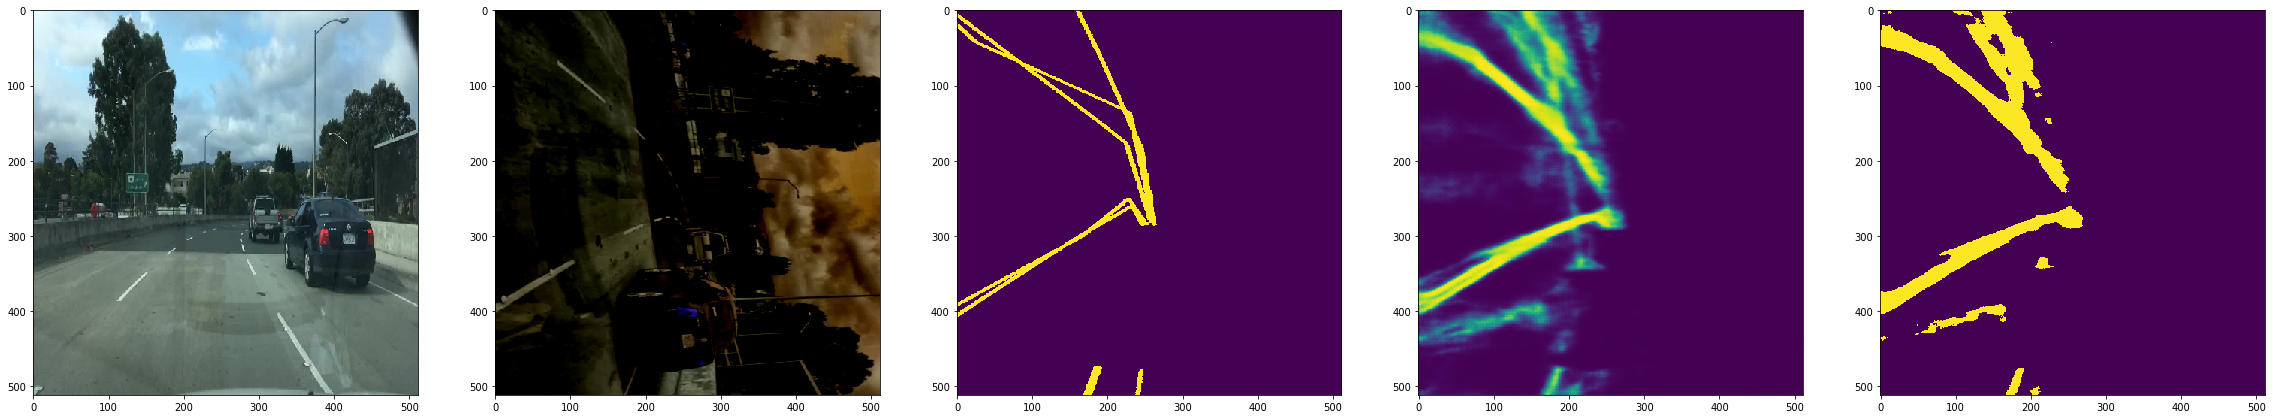

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


IOU :0.10713944835796795


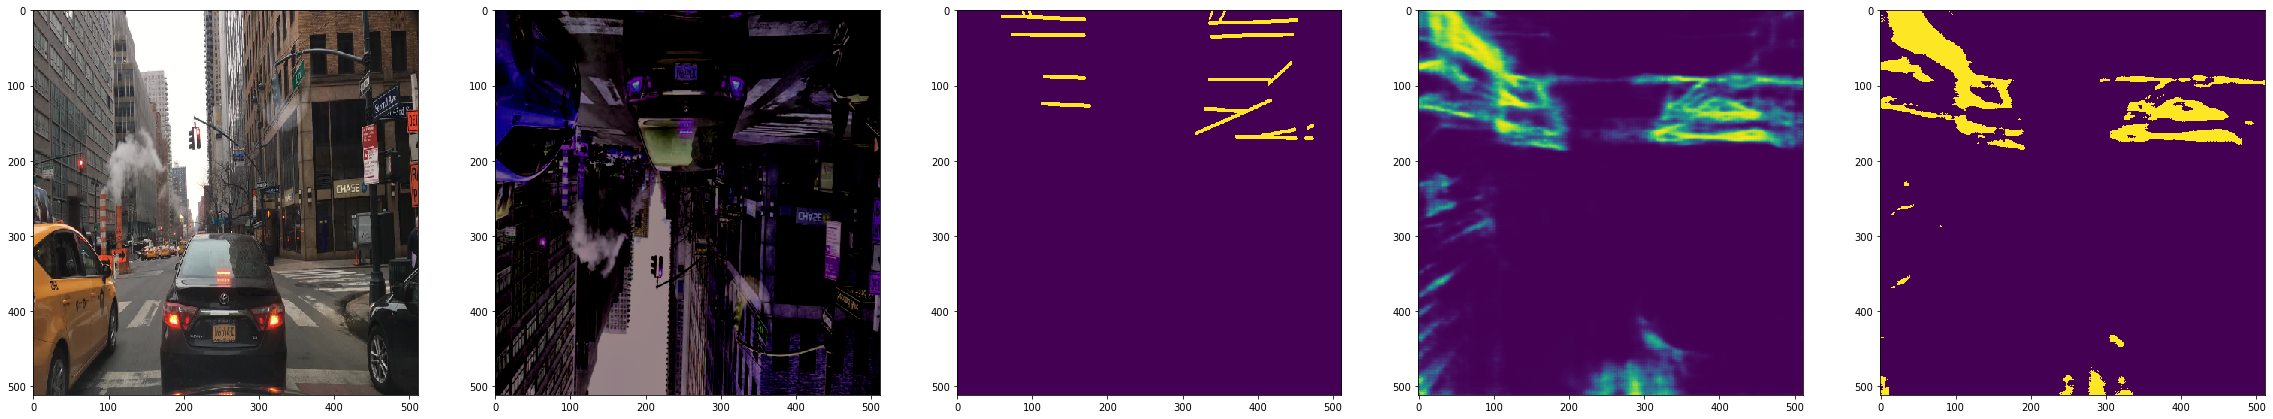

In [19]:
for i,index in enumerate(train_choices):
    
    img,mask = train_dataset[index]
    
    inputs = img.unsqueeze(0).cuda()
    targets = mask.unsqueeze(0).cuda()
       
    outputs = model(inputs)
       
    iou = fscore_batch(targets,outputs)
    print("IOU :{}".format(iou))
    
    prob_map = torch.nn.functional.softmax(outputs,dim=1)
    prob_map = prob_map.squeeze(0)
    prob_map = prob_map.cpu().detach().numpy()
        
    fig = plt.figure(figsize=(40,40))
    
    ax1 = fig.add_subplot(151)
    if not i:
        ax1.set_title('Image',fontsize=35 )
    image = Image.open(train_root + train_list[index])
    image = image.resize(input_size)
    plt.imshow(image)
    
    ax1 = fig.add_subplot(152)
    if not i:
        ax1.set_title('Augmented_Image',fontsize=35 )
    img_c = img.cpu().numpy()
    img_c = np.transpose(img_c,(1,2,0))
    plt.imshow(img_c)
    
    ax3 = fig.add_subplot(153)
    if not i:
        ax3.set_title('Ground Truth',fontsize= 35)
    targets = targets.squeeze(0).squeeze(0).cpu().numpy()
    plt.imshow(targets)
    
    ax4 = fig.add_subplot(154)
    if not i:
        ax4.set_title('Probability Map',fontsize= 35)
    _ , pred = torch.max(outputs,dim=1)
    pred = pred.cpu().numpy()
    plt.imshow(prob_map[1,:,:])
    
    ax5 = fig.add_subplot(155)
    if not i:
        ax5.set_title('Prediction',fontsize= 35)
    plt.imshow(pred[0,:,:])
        
    plt.show()

In [20]:
val_dataset = LaneDataset(cfg, augmentations = True , train=False)
val_choices = np.random.randint(0,len(val_dataset),5)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0.034600598086576215


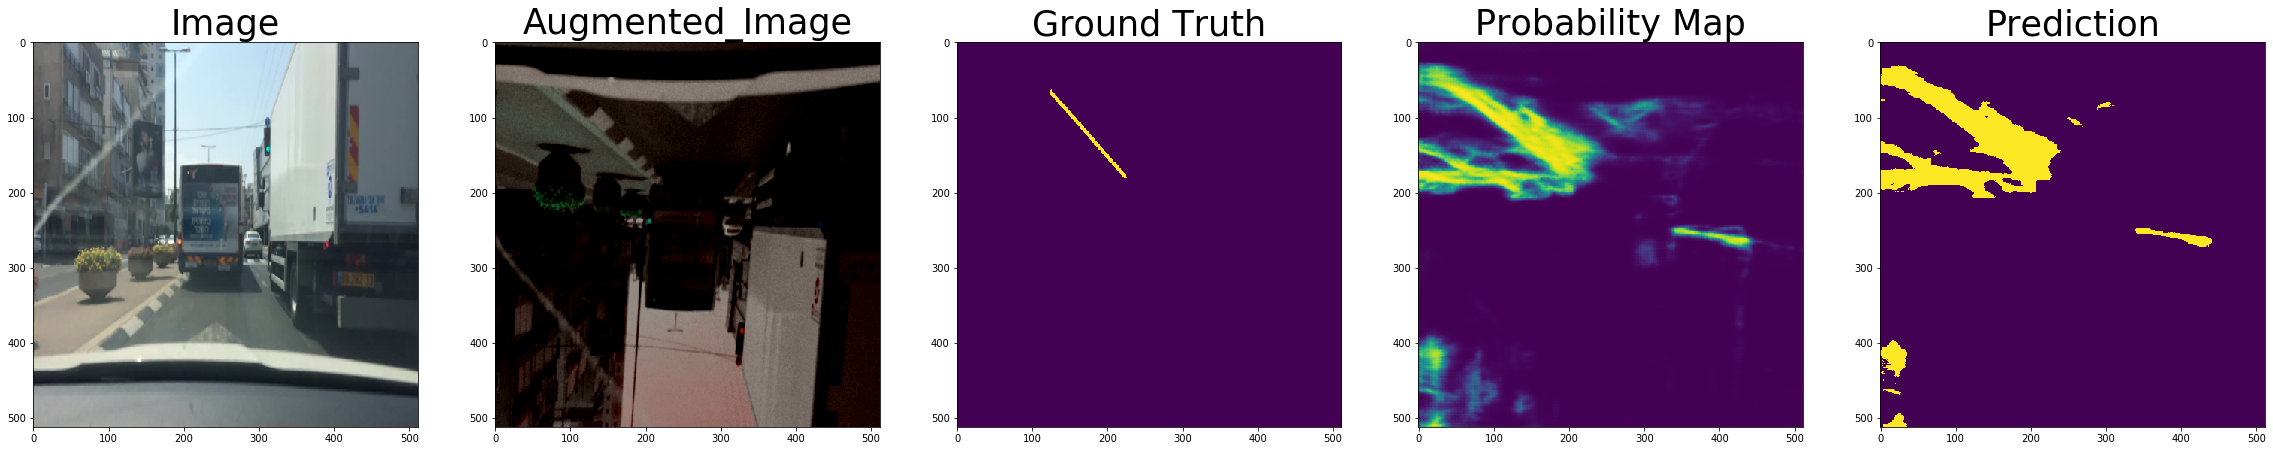

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0.028845439073017214


<Figure size 432x288 with 0 Axes>

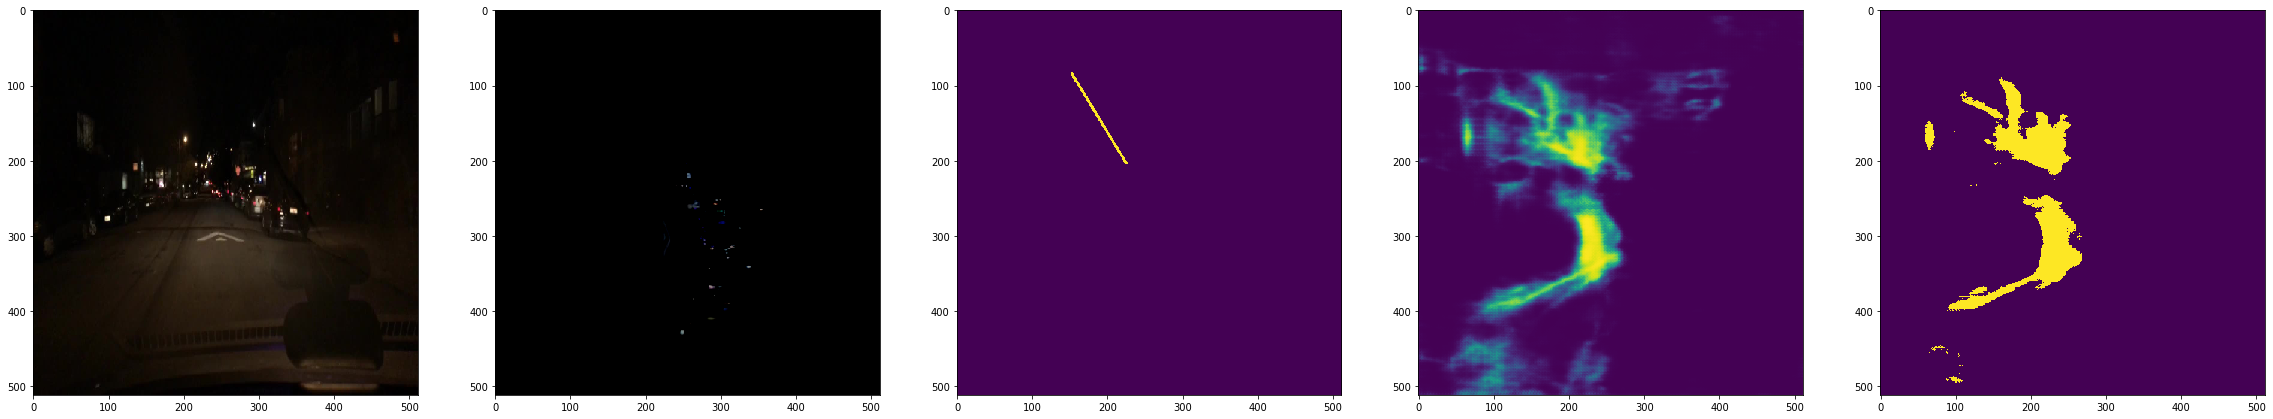

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0.29484547526522525


<Figure size 432x288 with 0 Axes>

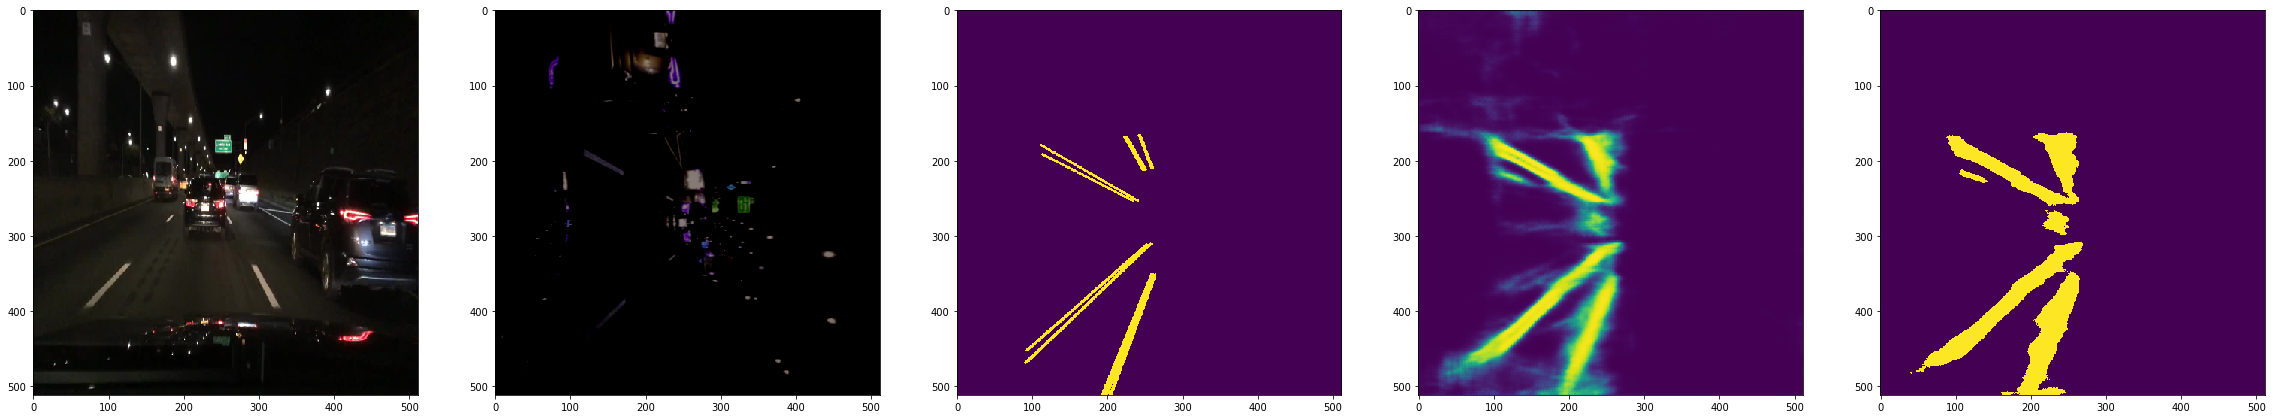

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0.15507063745074812


<Figure size 432x288 with 0 Axes>

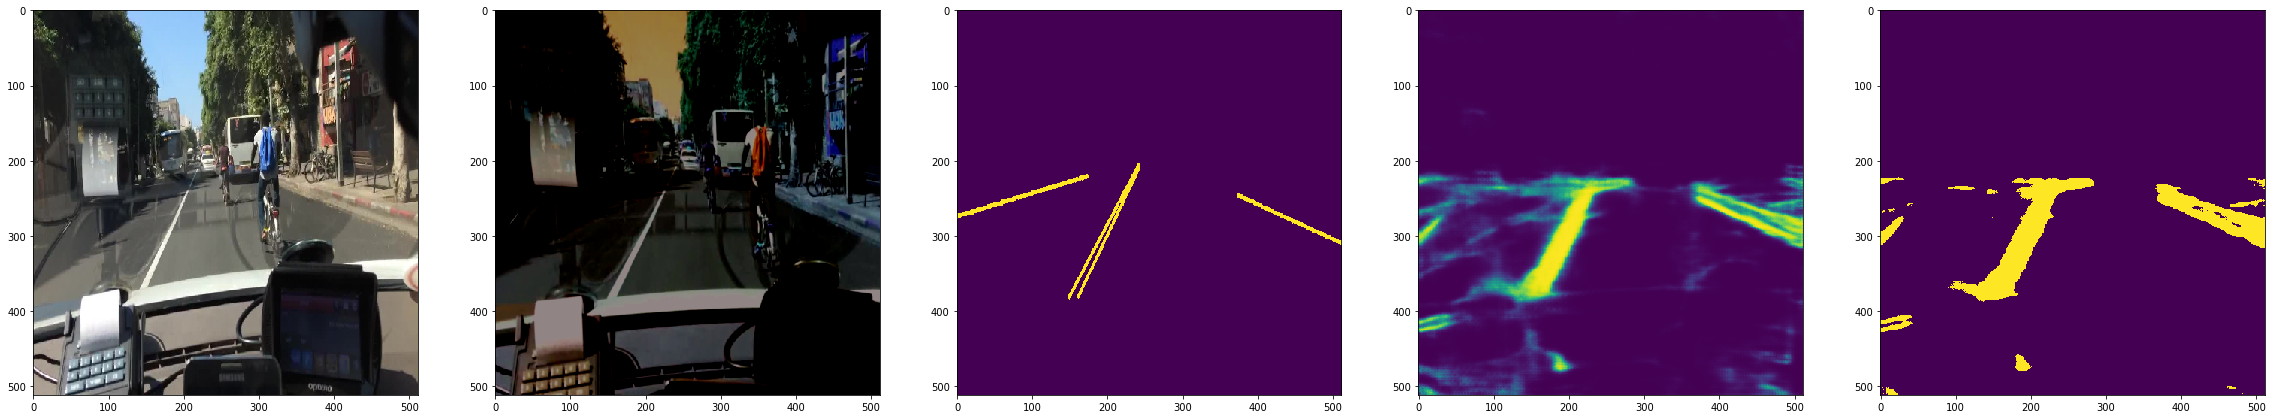

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0.019815946865062408


<Figure size 432x288 with 0 Axes>

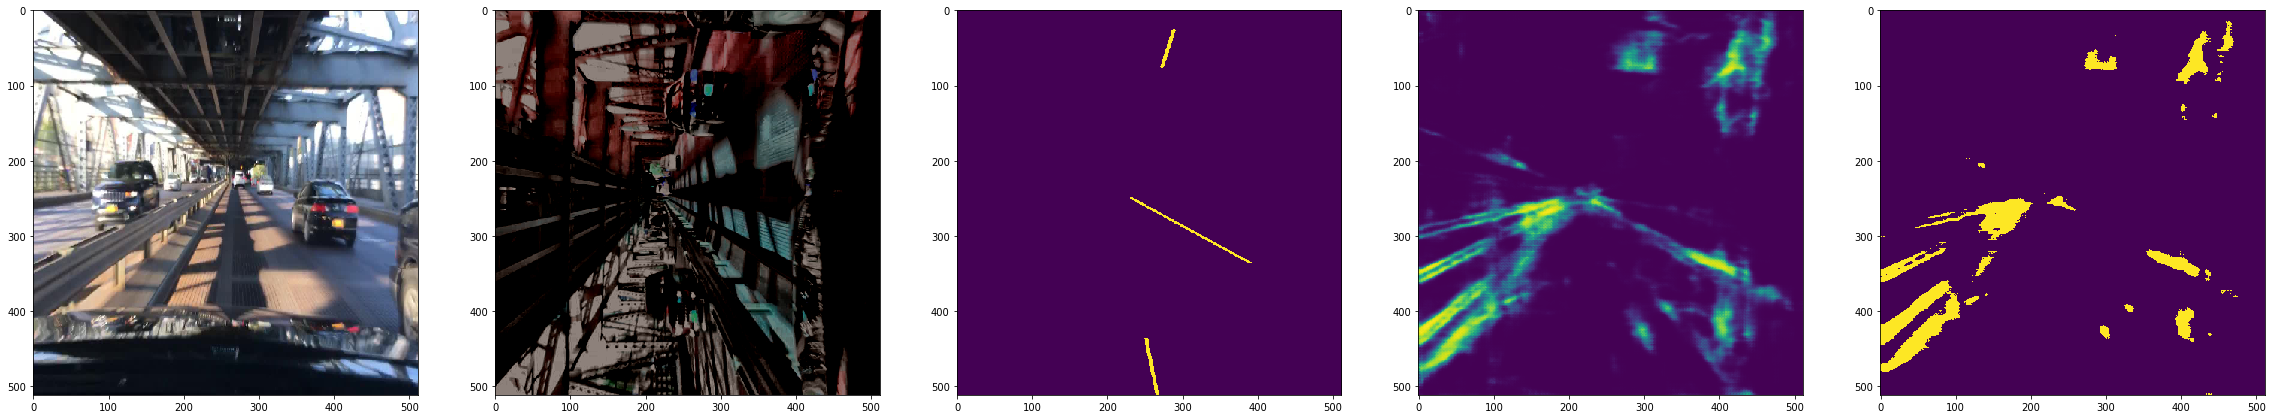

<Figure size 432x288 with 0 Axes>

In [21]:
for i,index in enumerate(val_choices):
    
    img,mask = val_dataset[index]
    
    inputs = img.unsqueeze(0).cuda()
    targets = mask.unsqueeze(0).cuda()
       
    outputs = model(inputs)
       
    iou = fscore_batch(targets,outputs)
    print(iou)
    
    prob_map = torch.nn.functional.softmax(outputs,dim=1)
    prob_map = prob_map.squeeze(0)
    prob_map = prob_map.cpu().detach().numpy()
        
    fig = plt.figure(figsize=(40,40))
    
    ax1 = fig.add_subplot(151)
    if not i:
        ax1.set_title('Image',fontsize=35 )
    image = Image.open(train_root + val_list[index])
    image = image.resize(input_size)
    plt.imshow(image)
    
    ax1 = fig.add_subplot(152)
    if not i:
        ax1.set_title('Augmented_Image',fontsize=35 )
    img_c = img.cpu().numpy()
    img_c = np.transpose(img_c,(1,2,0))
    plt.imshow(img_c)
    
    ax3 = fig.add_subplot(153)
    if not i:
        ax3.set_title('Ground Truth',fontsize= 35)
    targets = targets.squeeze(0).squeeze(0).cpu().numpy()
    
    plt.imshow(targets)
    
    ax4 = fig.add_subplot(154)
    if not i:
        ax4.set_title('Probability Map',fontsize= 35)
    _ , pred = torch.max(outputs,dim=1)
    pred = pred.cpu().numpy()
    plt.imshow(prob_map[1,:,:])
    
    ax5 = fig.add_subplot(155)
    if not i:
        ax5.set_title('Prediction',fontsize= 35)
    plt.imshow(pred[0,:,:])
        
    plt.show()
    plt.savefig('foo.png')